In [10]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageStat
import pandas as pd
from collections import defaultdict
import random
from skimage import feature, measure, filters
from scipy import ndimage
import warnings
warnings.filterwarnings('ignore')

# ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# ÏÑ§Ï†ï
TEST_DATA_PATH = '../../input/data/test'
SAMPLE_SIZE = 50  # Î∂ÑÏÑùÌï† ÏÉòÌîå Ïù¥ÎØ∏ÏßÄ Ïàò
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [11]:
# Ïù¥ÎØ∏ÏßÄ ÌååÏùº Î™©Î°ù Í∞ÄÏ†∏Ïò§Í∏∞
def get_image_files(path):
    """ÌÖåÏä§Ìä∏ Ìè¥ÎçîÏóêÏÑú Ïù¥ÎØ∏ÏßÄ ÌååÏùºÎì§ÏùÑ Í∞ÄÏ†∏ÏòµÎãàÎã§."""
    image_files = []
    for file in os.listdir(path):
        if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            image_files.append(os.path.join(path, file))
    return image_files

# Ïù¥ÎØ∏ÏßÄ ÌååÏùº Î™©Î°ù ÏÉùÏÑ±
image_files = get_image_files(TEST_DATA_PATH)
print(f"Ï¥ù Ïù¥ÎØ∏ÏßÄ ÌååÏùº Ïàò: {len(image_files)}")

# ÎûúÎç§ÌïòÍ≤å ÏÉòÌîå ÏÑ†ÌÉù
random.seed(42)
sample_files = random.sample(image_files, min(SAMPLE_SIZE, len(image_files)))
print(f"Î∂ÑÏÑùÌï† ÏÉòÌîå Ïàò: {len(sample_files)}")

# Ï≤´ Î™á Í∞ú ÌååÏùºÎ™Ö Ï∂úÎ†•
print("\nÏÉòÌîå ÌååÏùºÎì§:")
for i, file in enumerate(sample_files[:10]):
    print(f"{i+1}: {os.path.basename(file)}")


Ï¥ù Ïù¥ÎØ∏ÏßÄ ÌååÏùº Ïàò: 3140
Î∂ÑÏÑùÌï† ÏÉòÌîå Ïàò: 50

ÏÉòÌîå ÌååÏùºÎì§:
1: c34da2a0905551f7.jpg
2: 08590b0bed418283.jpg
3: bc41bdc300fbe45a.jpg
4: b7684f2d88132a50.jpg
5: 2e75bf13e029c0a9.jpg
6: f0231abdaf73d007.jpg
7: 45fa31f65f2a2944.jpg
8: 09eb83058248f2ac.jpg
9: 2e51d14abe1a4fd9.jpg
10: 3efe84af55458358.jpg


In [12]:
# Ïù¥ÎØ∏ÏßÄ Î∂ÑÏÑù Ìï®ÏàòÎì§
def analyze_image_properties(image_path):
    """Ïù¥ÎØ∏ÏßÄÏùò Í∏∞Î≥∏ ÏÜçÏÑ±Îì§ÏùÑ Î∂ÑÏÑùÌï©ÎãàÎã§."""
    # PILÎ°ú Ïù¥ÎØ∏ÏßÄ Î°úÎìú
    pil_img = Image.open(image_path)
    
    # OpenCVÎ°ú Ïù¥ÎØ∏ÏßÄ Î°úÎìú
    cv_img = cv2.imread(image_path)
    cv_img_rgb = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    
    properties = {
        'filename': os.path.basename(image_path),
        'size': pil_img.size,
        'width': pil_img.size[0],
        'height': pil_img.size[1],
        'aspect_ratio': pil_img.size[0] / pil_img.size[1],
        'mode': pil_img.mode,
        'format': pil_img.format
    }
    
    # ÏÉâÏÉÅ ÌÜµÍ≥Ñ
    if cv_img is not None:
        # Î∞ùÍ∏∞ ÌÜµÍ≥Ñ
        gray = cv2.cvtColor(cv_img, cv2.COLOR_BGR2GRAY)
        properties['mean_brightness'] = np.mean(gray)
        properties['std_brightness'] = np.std(gray)
        
        # ÏÉâÏÉÅ Ï±ÑÎÑêÎ≥Ñ ÌÜµÍ≥Ñ
        b_mean, g_mean, r_mean = np.mean(cv_img, axis=(0,1))
        properties['mean_blue'] = b_mean
        properties['mean_green'] = g_mean
        properties['mean_red'] = r_mean
        
        # ÎåÄÎπÑ Í≥ÑÏÇ∞ (ÌëúÏ§ÄÌé∏Ï∞® Í∏∞Î∞ò)
        properties['contrast'] = np.std(gray)
        
        # Ïó£ÏßÄ Í∞ïÎèÑ (Sobel)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        edge_strength = np.sqrt(sobelx**2 + sobely**2)
        properties['edge_strength'] = np.mean(edge_strength)
        
    return properties, cv_img_rgb

# ÏÉòÌîå Ïù¥ÎØ∏ÏßÄÎì§ Î∂ÑÏÑù
print("Ïù¥ÎØ∏ÏßÄÎì§ÏùÑ Î∂ÑÏÑù Ï§ë...")
image_data = []
sample_images = []

for i, img_path in enumerate(sample_files):
    try:
        props, img = analyze_image_properties(img_path)
        image_data.append(props)
        sample_images.append(img)
        
        if (i + 1) % 10 == 0:
            print(f"ÏßÑÌñâÎ•†: {i+1}/{len(sample_files)}")
    except Exception as e:
        print(f"Ïò§Î•ò Î∞úÏÉù {img_path}: {e}")

# Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏúºÎ°ú Î≥ÄÌôò
df = pd.DataFrame(image_data)
print(f"\nÎ∂ÑÏÑù ÏôÑÎ£å! Ï¥ù {len(df)}Í∞ú Ïù¥ÎØ∏ÏßÄ Î∂ÑÏÑùÎê®")
print("\nÍ∏∞Î≥∏ ÌÜµÍ≥Ñ:")
print(df.describe())


Ïù¥ÎØ∏ÏßÄÎì§ÏùÑ Î∂ÑÏÑù Ï§ë...
ÏßÑÌñâÎ•†: 10/50
ÏßÑÌñâÎ•†: 20/50
ÏßÑÌñâÎ•†: 30/50
ÏßÑÌñâÎ•†: 40/50
ÏßÑÌñâÎ•†: 50/50

Î∂ÑÏÑù ÏôÑÎ£å! Ï¥ù 50Í∞ú Ïù¥ÎØ∏ÏßÄ Î∂ÑÏÑùÎê®

Í∏∞Î≥∏ ÌÜµÍ≥Ñ:
            width      height  aspect_ratio  mean_brightness  std_brightness  \
count   50.000000   50.000000     50.000000        50.000000       50.000000   
mean   517.540000  518.680000      1.048516       179.271636       45.749413   
std     82.347747   82.492904      0.327863        33.612847       21.799722   
min    384.000000  383.000000      0.563050        96.788131       24.308062   
25%    443.000000  443.000000      0.749577       157.198725       29.789312   
50%    517.000000  517.000000      1.041831       194.313890       37.125141   
75%    591.000000  591.000000      1.334086       205.346976       53.741683   
max    682.000000  682.000000      1.780679       220.160848      111.112004   

        mean_blue  mean_green    mean_red    contrast  edge_strength  
count   50.000000   50.000000  

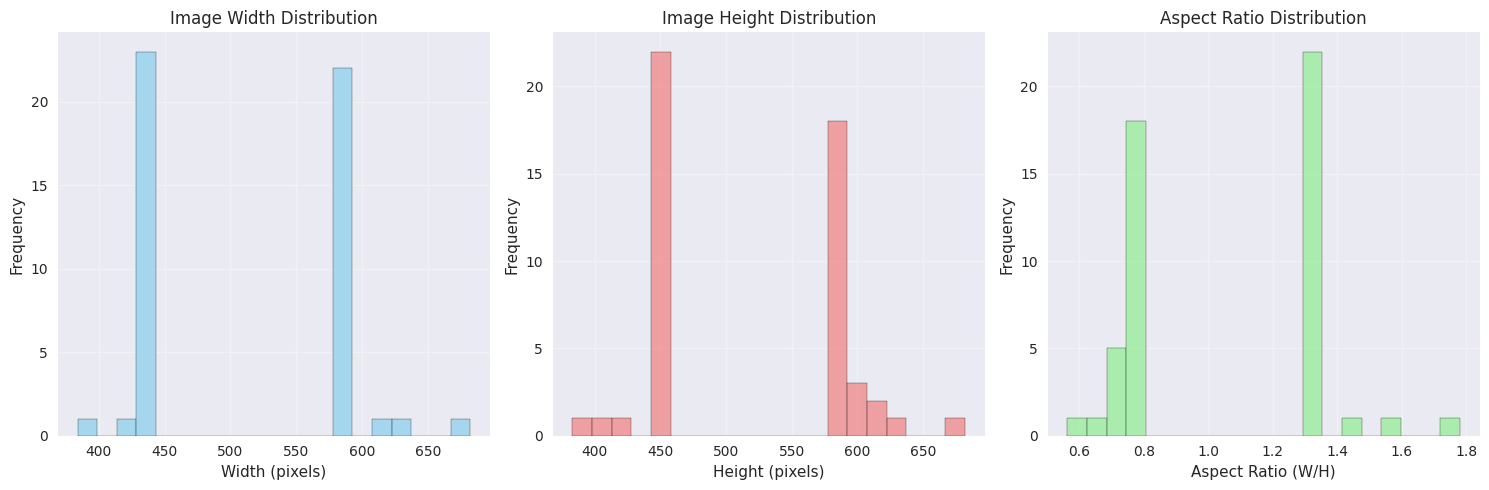

=== Ïù¥ÎØ∏ÏßÄ ÌÅ¨Í∏∞ Î∂ÑÏÑù ===
ÎÑàÎπÑ Î≤îÏúÑ: 384 ~ 682
ÎÜíÏù¥ Î≤îÏúÑ: 383 ~ 682
Ï¢ÖÌö°ÎπÑ Î≤îÏúÑ: 0.563 ~ 1.781
Í≥†Ïú†Ìïú ÌÅ¨Í∏∞Ïùò Ïàò: 12
‚úÖ ÌÅ¨Í∏∞ Ï°∞Ï†ï Ï¶ùÍ∞ïÏù¥ Ï†ÅÏö©Îêú Í≤ÉÏúºÎ°ú Î≥¥ÏûÖÎãàÎã§.


In [13]:
# 1. Ïù¥ÎØ∏ÏßÄ ÌÅ¨Í∏∞ Î∂ÑÏÑù (ÌÅ¨Í∏∞ Ï°∞Ï†ï/ÌÅ¨Î°≠Ìïë Ï¶ùÍ∞ï ÌÉêÏßÄ)
plt.figure(figsize=(15, 5))

# Ïù¥ÎØ∏ÏßÄ ÎÑàÎπÑ Î∂ÑÌè¨
plt.subplot(1, 3, 1)
plt.hist(df['width'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Image Width Distribution')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Ïù¥ÎØ∏ÏßÄ ÎÜíÏù¥ Î∂ÑÌè¨
plt.subplot(1, 3, 2)
plt.hist(df['height'], bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
plt.title('Image Height Distribution')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Ï¢ÖÌö°ÎπÑ Î∂ÑÌè¨
plt.subplot(1, 3, 3)
plt.hist(df['aspect_ratio'], bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
plt.title('Aspect Ratio Distribution')
plt.xlabel('Aspect Ratio (W/H)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ÌÅ¨Í∏∞ ÌÜµÍ≥Ñ Ï∂úÎ†•
print("=== Ïù¥ÎØ∏ÏßÄ ÌÅ¨Í∏∞ Î∂ÑÏÑù ===")
print(f"ÎÑàÎπÑ Î≤îÏúÑ: {df['width'].min()} ~ {df['width'].max()}")
print(f"ÎÜíÏù¥ Î≤îÏúÑ: {df['height'].min()} ~ {df['height'].max()}")
print(f"Ï¢ÖÌö°ÎπÑ Î≤îÏúÑ: {df['aspect_ratio'].min():.3f} ~ {df['aspect_ratio'].max():.3f}")
print(f"Í≥†Ïú†Ìïú ÌÅ¨Í∏∞Ïùò Ïàò: {len(df[['width', 'height']].drop_duplicates())}")

# ÌÅ¨Í∏∞ Ï°∞Ï†ï Ï¶ùÍ∞ï Í∞ÄÎä•ÏÑ± Î∂ÑÏÑù
if len(df[['width', 'height']].drop_duplicates()) > 1:
    print("‚úÖ ÌÅ¨Í∏∞ Ï°∞Ï†ï Ï¶ùÍ∞ïÏù¥ Ï†ÅÏö©Îêú Í≤ÉÏúºÎ°ú Î≥¥ÏûÖÎãàÎã§.")
else:
    print("‚ùå Î™®Îì† Ïù¥ÎØ∏ÏßÄÍ∞Ä ÎèôÏùºÌïú ÌÅ¨Í∏∞ÏûÖÎãàÎã§.")


In [14]:
# 2. Î∞ùÍ∏∞ Î∞è ÎåÄÎπÑ Î∂ÑÏÑù (Î∞ùÍ∏∞/ÎåÄÎπÑ Ï¶ùÍ∞ï ÌÉêÏßÄ)
plt.figure(figsize=(15, 5))

# Î∞ùÍ∏∞ Î∂ÑÌè¨
plt.subplot(1, 3, 1)
plt.hist(df['mean_brightness'], bins=20, alpha=0.7, color='gold', edgecolor='black')
plt.title('Brightness Distribution')
plt.xlabel('Mean Brightness (0-255)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# ÎåÄÎπÑ Î∂ÑÌè¨
plt.subplot(1, 3, 2)
plt.hist(df['contrast'], bins=20, alpha=0.7, color='orange', edgecolor='black')
plt.title('Contrast Distribution')
plt.xlabel('Contrast (Std Dev)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Î∞ùÍ∏∞ vs ÎåÄÎπÑ ÏÇ∞Ï†êÎèÑ
plt.subplot(1, 3, 3)
plt.scatter(df['mean_brightness'], df['contrast'], alpha=0.6, color='purple')
plt.title('Brightness vs Contrast')
plt.xlabel('Mean Brightness')
plt.ylabel('Contrast')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Î∞ùÍ∏∞/ÎåÄÎπÑ ÌÜµÍ≥Ñ Ï∂úÎ†•
print("=== Î∞ùÍ∏∞ Î∞è ÎåÄÎπÑ Î∂ÑÏÑù ===")
print(f"Î∞ùÍ∏∞ Î≤îÏúÑ: {df['mean_brightness'].min():.2f} ~ {df['mean_brightness'].max():.2f}")
print(f"ÎåÄÎπÑ Î≤îÏúÑ: {df['contrast'].min():.2f} ~ {df['contrast'].max():.2f}")
print(f"Î∞ùÍ∏∞ ÌëúÏ§ÄÌé∏Ï∞®: {df['mean_brightness'].std():.2f}")
print(f"ÎåÄÎπÑ ÌëúÏ§ÄÌé∏Ï∞®: {df['contrast'].std():.2f}")

# Î∞ùÍ∏∞/ÎåÄÎπÑ Ï¶ùÍ∞ï Í∞ÄÎä•ÏÑ± Î∂ÑÏÑù
brightness_cv = df['mean_brightness'].std() / df['mean_brightness'].mean()
contrast_cv = df['contrast'].std() / df['contrast'].mean()

if brightness_cv > 0.15:
    print("‚úÖ Î∞ùÍ∏∞ Ï°∞Ï†ï Ï¶ùÍ∞ïÏù¥ Ï†ÅÏö©Îêú Í≤ÉÏúºÎ°ú Î≥¥ÏûÖÎãàÎã§.")
else:
    print("‚ùå Î∞ùÍ∏∞Í∞Ä ÏùºÍ¥ÄÎê©ÎãàÎã§.")

if contrast_cv > 0.15:
    print("‚úÖ ÎåÄÎπÑ Ï°∞Ï†ï Ï¶ùÍ∞ïÏù¥ Ï†ÅÏö©Îêú Í≤ÉÏúºÎ°ú Î≥¥ÏûÖÎãàÎã§.")
else:
    print("‚ùå ÎåÄÎπÑÍ∞Ä ÏùºÍ¥ÄÎê©ÎãàÎã§.")


=== Î∞ùÍ∏∞ Î∞è ÎåÄÎπÑ Î∂ÑÏÑù ===
Î∞ùÍ∏∞ Î≤îÏúÑ: 96.79 ~ 220.16
ÎåÄÎπÑ Î≤îÏúÑ: 24.31 ~ 111.11
Î∞ùÍ∏∞ ÌëúÏ§ÄÌé∏Ï∞®: 33.61
ÎåÄÎπÑ ÌëúÏ§ÄÌé∏Ï∞®: 21.80
‚úÖ Î∞ùÍ∏∞ Ï°∞Ï†ï Ï¶ùÍ∞ïÏù¥ Ï†ÅÏö©Îêú Í≤ÉÏúºÎ°ú Î≥¥ÏûÖÎãàÎã§.
‚úÖ ÎåÄÎπÑ Ï°∞Ï†ï Ï¶ùÍ∞ïÏù¥ Ï†ÅÏö©Îêú Í≤ÉÏúºÎ°ú Î≥¥ÏûÖÎãàÎã§.


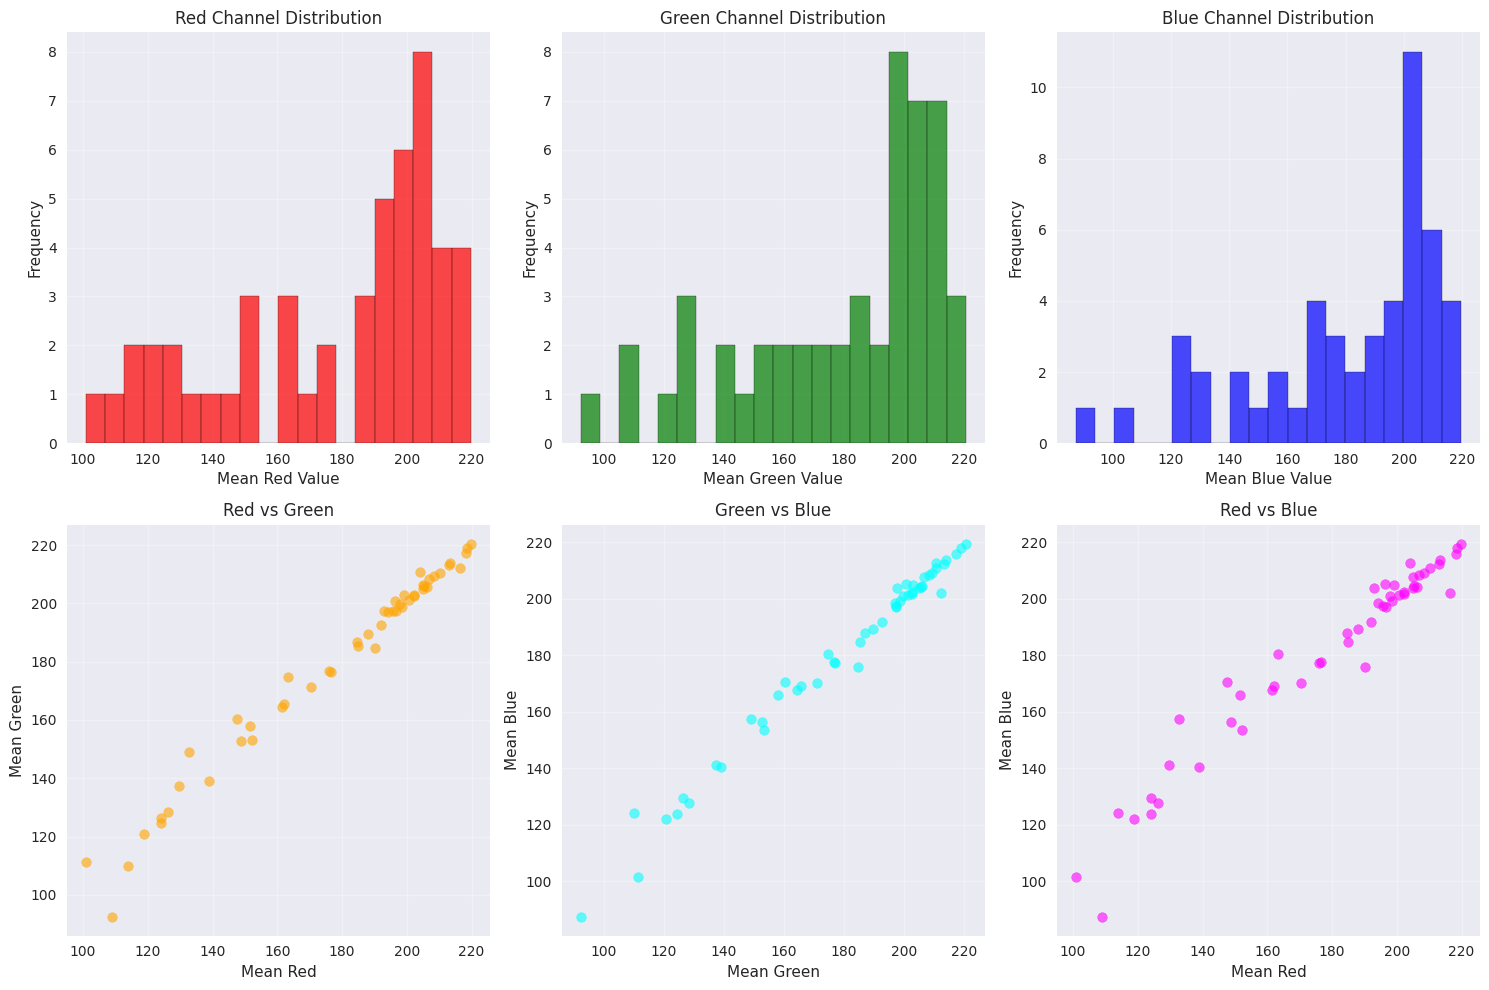

=== ÏÉâÏÉÅ Î∂ÑÏÑù ===
Îπ®Í∞ÑÏÉâ Î≤îÏúÑ: 100.94 ~ 219.75
Ï¥àÎ°ùÏÉâ Î≤îÏúÑ: 92.37 ~ 220.54
ÌååÎûÄÏÉâ Î≤îÏúÑ: 87.29 ~ 219.62
Îπ®Í∞ÑÏÉâ Î≥ÄÏù¥Í≥ÑÏàò: 0.192
Ï¥àÎ°ùÏÉâ Î≥ÄÏù¥Í≥ÑÏàò: 0.187
ÌååÎûÄÏÉâ Î≥ÄÏù¥Í≥ÑÏàò: 0.183
‚úÖ ÏÉâÏÉÅ Ï°∞Ï†ï Ï¶ùÍ∞ïÏù¥ Ï†ÅÏö©Îêú Í≤ÉÏúºÎ°ú Î≥¥ÏûÖÎãàÎã§.


In [15]:
# 3. ÏÉâÏÉÅ Î∂ÑÏÑù (ÏÉâÏÉÅ Ï°∞Ï†ï Ï¶ùÍ∞ï ÌÉêÏßÄ)
plt.figure(figsize=(15, 10))

# RGB Ï±ÑÎÑêÎ≥Ñ Î∂ÑÌè¨
plt.subplot(2, 3, 1)
plt.hist(df['mean_red'], bins=20, alpha=0.7, color='red', edgecolor='black')
plt.title('Red Channel Distribution')
plt.xlabel('Mean Red Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 2)
plt.hist(df['mean_green'], bins=20, alpha=0.7, color='green', edgecolor='black')
plt.title('Green Channel Distribution')
plt.xlabel('Mean Green Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 3)
plt.hist(df['mean_blue'], bins=20, alpha=0.7, color='blue', edgecolor='black')
plt.title('Blue Channel Distribution')
plt.xlabel('Mean Blue Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# RGB Ï±ÑÎÑê Í∞Ñ Í¥ÄÍ≥Ñ
plt.subplot(2, 3, 4)
plt.scatter(df['mean_red'], df['mean_green'], alpha=0.6, color='orange')
plt.title('Red vs Green')
plt.xlabel('Mean Red')
plt.ylabel('Mean Green')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
plt.scatter(df['mean_green'], df['mean_blue'], alpha=0.6, color='cyan')
plt.title('Green vs Blue')
plt.xlabel('Mean Green')
plt.ylabel('Mean Blue')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
plt.scatter(df['mean_red'], df['mean_blue'], alpha=0.6, color='magenta')
plt.title('Red vs Blue')
plt.xlabel('Mean Red')
plt.ylabel('Mean Blue')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ÏÉâÏÉÅ ÌÜµÍ≥Ñ Ï∂úÎ†•
print("=== ÏÉâÏÉÅ Î∂ÑÏÑù ===")
print(f"Îπ®Í∞ÑÏÉâ Î≤îÏúÑ: {df['mean_red'].min():.2f} ~ {df['mean_red'].max():.2f}")
print(f"Ï¥àÎ°ùÏÉâ Î≤îÏúÑ: {df['mean_green'].min():.2f} ~ {df['mean_green'].max():.2f}")
print(f"ÌååÎûÄÏÉâ Î≤îÏúÑ: {df['mean_blue'].min():.2f} ~ {df['mean_blue'].max():.2f}")

# ÏÉâÏÉÅ Ï¶ùÍ∞ï Í∞ÄÎä•ÏÑ± Î∂ÑÏÑù
red_cv = df['mean_red'].std() / df['mean_red'].mean()
green_cv = df['mean_green'].std() / df['mean_green'].mean()
blue_cv = df['mean_blue'].std() / df['mean_blue'].mean()

print(f"Îπ®Í∞ÑÏÉâ Î≥ÄÏù¥Í≥ÑÏàò: {red_cv:.3f}")
print(f"Ï¥àÎ°ùÏÉâ Î≥ÄÏù¥Í≥ÑÏàò: {green_cv:.3f}")
print(f"ÌååÎûÄÏÉâ Î≥ÄÏù¥Í≥ÑÏàò: {blue_cv:.3f}")

if max(red_cv, green_cv, blue_cv) > 0.15:
    print("‚úÖ ÏÉâÏÉÅ Ï°∞Ï†ï Ï¶ùÍ∞ïÏù¥ Ï†ÅÏö©Îêú Í≤ÉÏúºÎ°ú Î≥¥ÏûÖÎãàÎã§.")
else:
    print("‚ùå ÏÉâÏÉÅÏù¥ ÏùºÍ¥ÄÎê©ÎãàÎã§.")


In [16]:
# 4. ÌöåÏ†Ñ Î∂ÑÏÑù (ÌöåÏ†Ñ Ï¶ùÍ∞ï ÌÉêÏßÄ)
def detect_rotation_features(image):
    """Ïù¥ÎØ∏ÏßÄÏóêÏÑú ÌöåÏ†Ñ Í¥ÄÎ†® ÌäπÏßïÏùÑ Ï∂îÏ∂úÌï©ÎãàÎã§."""
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image
    
    # Ïó£ÏßÄ Í≤ÄÏ∂ú
    edges = cv2.Canny(gray, 50, 150)
    
    # Hough Î≥ÄÌôòÏúºÎ°ú ÏßÅÏÑ† Í≤ÄÏ∂ú
    lines = cv2.HoughLines(edges, 1, np.pi/180, threshold=100)
    
    angles = []
    if lines is not None and len(lines) > 0:
        # linesÏùò Ï∞®ÏõêÏùÑ ÌôïÏù∏ÌïòÍ≥† Ï†ÅÏ†àÌûà Ï≤òÎ¶¨
        if len(lines.shape) == 3:
            # 3Ï∞®Ïõê Î∞∞Ïó¥Ïù∏ Í≤ΩÏö∞ [[[rho, theta]], ...] -> [[rho, theta], ...]
            lines = lines[:, 0, :]
        
        # ÏÉÅÏúÑ 20Í∞ú ÏßÅÏÑ†Îßå ÏÇ¨Ïö©
        for line_data in lines[:20]:
            if len(line_data) >= 2:  # ÏïàÏ†ÑÏÑ± Ï≤¥ÌÅ¨
                rho, theta = line_data[0], line_data[1]
                angle = np.degrees(theta)
                # Í∞ÅÎèÑÎ•º -90~90 Î≤îÏúÑÎ°ú Ï†ïÍ∑úÌôî
                if angle > 90:
                    angle -= 180
                angles.append(angle)
    
    return {
        'dominant_angles': angles,
        'num_lines': len(angles) if angles else 0,
        'angle_std': np.std(angles) if angles else 0,
        'edge_density': np.sum(edges > 0) / (edges.shape[0] * edges.shape[1])
    }

# ÌöåÏ†Ñ ÌäπÏßï Î∂ÑÏÑù
print("ÌöåÏ†Ñ ÌäπÏßïÏùÑ Î∂ÑÏÑù Ï§ë...")
rotation_features = []

for i, img in enumerate(sample_images[:20]):  # Ï≤òÎ¶¨ ÏãúÍ∞ÑÏùÑ ÏúÑÌï¥ 20Í∞úÎßå Î∂ÑÏÑù
    if img is not None:
        features = detect_rotation_features(img)
        features['filename'] = df.iloc[i]['filename']
        rotation_features.append(features)
    
    if (i + 1) % 5 == 0:
        print(f"ÌöåÏ†Ñ Î∂ÑÏÑù ÏßÑÌñâÎ•†: {i+1}/20")

# ÌöåÏ†Ñ ÌäπÏßï ÏãúÍ∞ÅÌôî
plt.figure(figsize=(15, 5))

# Ïó£ÏßÄ Î∞ÄÎèÑ Î∂ÑÌè¨
plt.subplot(1, 3, 1)
edge_densities = [f['edge_density'] for f in rotation_features]
plt.hist(edge_densities, bins=15, alpha=0.7, color='teal', edgecolor='black')
plt.title('Edge Density Distribution')
plt.xlabel('Edge Density')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Í≤ÄÏ∂úÎêú ÏßÅÏÑ† Ïàò Î∂ÑÌè¨
plt.subplot(1, 3, 2)
num_lines = [f['num_lines'] for f in rotation_features]
plt.hist(num_lines, bins=15, alpha=0.7, color='coral', edgecolor='black')
plt.title('Number of Detected Lines')
plt.xlabel('Number of Lines')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Í∞ÅÎèÑ Î∂ÑÌè¨ (Î™®Îì† Í∞ÅÎèÑ)
plt.subplot(1, 3, 3)
all_angles = []
for f in rotation_features:
    all_angles.extend(f['dominant_angles'])

if all_angles:
    plt.hist(all_angles, bins=30, alpha=0.7, color='mediumpurple', edgecolor='black')
    plt.title('Dominant Angles Distribution')
    plt.xlabel('Angle (degrees)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ÌöåÏ†Ñ Î∂ÑÏÑù Í≤∞Í≥º
print("=== ÌöåÏ†Ñ Î∂ÑÏÑù ===")
if all_angles:
    print(f"Í≤ÄÏ∂úÎêú Ï£ºÏöî Í∞ÅÎèÑ Ïàò: {len(all_angles)}")
    print(f"Í∞ÅÎèÑ Î≤îÏúÑ: {min(all_angles):.1f}¬∞ ~ {max(all_angles):.1f}¬∞")
    print(f"Í∞ÅÎèÑ ÌëúÏ§ÄÌé∏Ï∞®: {np.std(all_angles):.2f}¬∞")
    
    # ÏàòÏßÅ/ÏàòÌèâÏÑ† ÎπÑÏú®
    vertical_horizontal = sum(1 for angle in all_angles if abs(angle) < 10 or abs(angle) > 80)
    diagonal = len(all_angles) - vertical_horizontal
    
    print(f"ÏàòÏßÅ/ÏàòÌèâÏÑ†: {vertical_horizontal}Í∞ú")
    print(f"ÎåÄÍ∞ÅÏÑ†: {diagonal}Í∞ú")
    
    if diagonal > vertical_horizontal * 0.3:
        print("‚úÖ ÌöåÏ†Ñ Ï¶ùÍ∞ïÏù¥ Ï†ÅÏö©Îêú Í≤ÉÏúºÎ°ú Î≥¥ÏûÖÎãàÎã§.")
    else:
        print("‚ùå ÌöåÏ†Ñ Ï¶ùÍ∞ïÏùò Î™ÖÌôïÌïú Ï¶ùÍ±∞Í∞Ä ÏóÜÏäµÎãàÎã§.")
else:
    print("‚ùå ÏßÅÏÑ†ÏùÑ Ï∂©Î∂ÑÌûà Í≤ÄÏ∂úÌïòÏßÄ Î™ªÌñàÏäµÎãàÎã§.")


ÌöåÏ†Ñ ÌäπÏßïÏùÑ Î∂ÑÏÑù Ï§ë...
ÌöåÏ†Ñ Î∂ÑÏÑù ÏßÑÌñâÎ•†: 5/20
ÌöåÏ†Ñ Î∂ÑÏÑù ÏßÑÌñâÎ•†: 10/20
ÌöåÏ†Ñ Î∂ÑÏÑù ÏßÑÌñâÎ•†: 15/20
ÌöåÏ†Ñ Î∂ÑÏÑù ÏßÑÌñâÎ•†: 20/20


=== ÌöåÏ†Ñ Î∂ÑÏÑù ===
Í≤ÄÏ∂úÎêú Ï£ºÏöî Í∞ÅÎèÑ Ïàò: 380
Í∞ÅÎèÑ Î≤îÏúÑ: -89.0¬∞ ~ 90.0¬∞
Í∞ÅÎèÑ ÌëúÏ§ÄÌé∏Ï∞®: 47.05¬∞
ÏàòÏßÅ/ÏàòÌèâÏÑ†: 253Í∞ú
ÎåÄÍ∞ÅÏÑ†: 127Í∞ú
‚úÖ ÌöåÏ†Ñ Ï¶ùÍ∞ïÏù¥ Ï†ÅÏö©Îêú Í≤ÉÏúºÎ°ú Î≥¥ÏûÖÎãàÎã§.


ÎåÄÏπ≠ÏÑ±ÏùÑ Î∂ÑÏÑù Ï§ë...
ÎåÄÏπ≠ÏÑ± Î∂ÑÏÑù ÏßÑÌñâÎ•†: 5/25
ÎåÄÏπ≠ÏÑ± Î∂ÑÏÑù ÏßÑÌñâÎ•†: 10/25
ÎåÄÏπ≠ÏÑ± Î∂ÑÏÑù ÏßÑÌñâÎ•†: 15/25
ÎåÄÏπ≠ÏÑ± Î∂ÑÏÑù ÏßÑÌñâÎ•†: 20/25
ÎåÄÏπ≠ÏÑ± Î∂ÑÏÑù ÏßÑÌñâÎ•†: 25/25


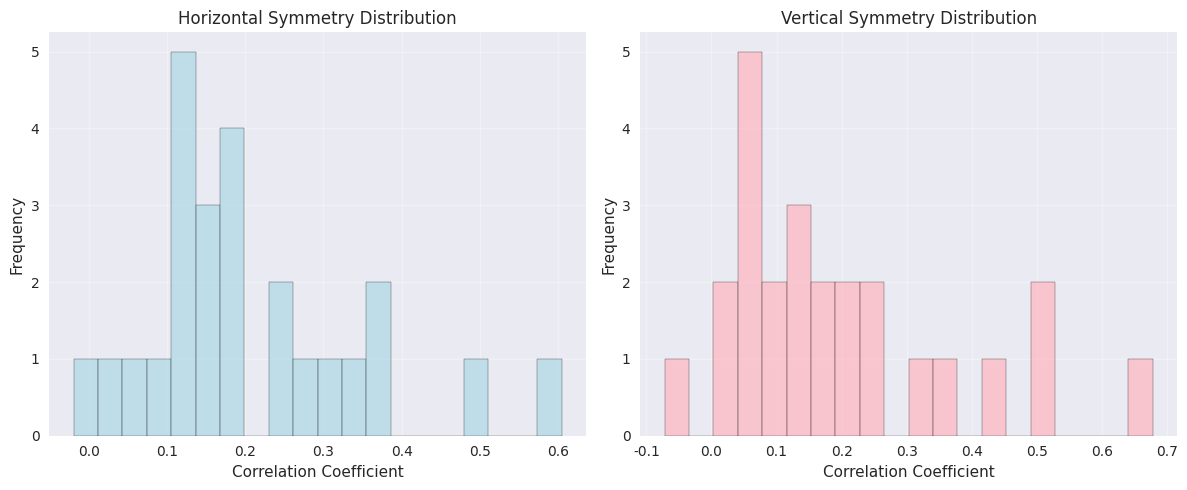

=== ÌîåÎ¶¨Ìïë Î∂ÑÏÑù ===
Ï¢åÏö∞ ÎåÄÏπ≠ÏÑ± ÌèâÍ∑†: 0.211
ÏÉÅÌïò ÎåÄÏπ≠ÏÑ± ÌèâÍ∑†: 0.196
Ï¢åÏö∞ ÎåÄÏπ≠ÏÑ± ÌëúÏ§ÄÌé∏Ï∞®: 0.141
ÏÉÅÌïò ÎåÄÏπ≠ÏÑ± ÌëúÏ§ÄÌé∏Ï∞®: 0.180
ÎÜíÏùÄ Ï¢åÏö∞ ÎåÄÏπ≠ÏÑ± Ïù¥ÎØ∏ÏßÄ: 0Í∞ú
ÎÜíÏùÄ ÏÉÅÌïò ÎåÄÏπ≠ÏÑ± Ïù¥ÎØ∏ÏßÄ: 0Í∞ú
‚úÖ ÌîåÎ¶¨Ìïë Ï¶ùÍ∞ïÏù¥ Ï†ÅÏö©ÎêòÏóàÏùÑ Í∞ÄÎä•ÏÑ±Ïù¥ ÏûàÏäµÎãàÎã§.


In [17]:
# 5. ÌîåÎ¶¨Ìïë Î∂ÑÏÑù (Ï¢åÏö∞/ÏÉÅÌïò ÎåÄÏπ≠ÏÑ± Î∂ÑÏÑù)
def analyze_symmetry(image):
    """Ïù¥ÎØ∏ÏßÄÏùò ÎåÄÏπ≠ÏÑ±ÏùÑ Î∂ÑÏÑùÌï©ÎãàÎã§."""
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image
    
    h, w = gray.shape
    
    # Ï¢åÏö∞ ÎåÄÏπ≠ÏÑ± Î∂ÑÏÑù
    left_half = gray[:, :w//2]
    right_half = gray[:, w//2:]
    right_half_flipped = np.fliplr(right_half)
    
    # ÌÅ¨Í∏∞Î•º ÎßûÏ∂§
    min_width = min(left_half.shape[1], right_half_flipped.shape[1])
    left_half = left_half[:, :min_width]
    right_half_flipped = right_half_flipped[:, :min_width]
    
    # Ï¢åÏö∞ ÎåÄÏπ≠ÏÑ± Í≥ÑÏÇ∞ (Íµ¨Ï°∞ Ïú†ÏÇ¨ÎèÑ)
    horizontal_symmetry = np.corrcoef(left_half.flatten(), right_half_flipped.flatten())[0, 1]
    if np.isnan(horizontal_symmetry):
        horizontal_symmetry = 0
    
    # ÏÉÅÌïò ÎåÄÏπ≠ÏÑ± Î∂ÑÏÑù
    top_half = gray[:h//2, :]
    bottom_half = gray[h//2:, :]
    bottom_half_flipped = np.flipud(bottom_half)
    
    # ÌÅ¨Í∏∞Î•º ÎßûÏ∂§
    min_height = min(top_half.shape[0], bottom_half_flipped.shape[0])
    top_half = top_half[:min_height, :]
    bottom_half_flipped = bottom_half_flipped[:min_height, :]
    
    # ÏÉÅÌïò ÎåÄÏπ≠ÏÑ± Í≥ÑÏÇ∞
    vertical_symmetry = np.corrcoef(top_half.flatten(), bottom_half_flipped.flatten())[0, 1]
    if np.isnan(vertical_symmetry):
        vertical_symmetry = 0
    
    return {
        'horizontal_symmetry': horizontal_symmetry,
        'vertical_symmetry': vertical_symmetry
    }

# ÎåÄÏπ≠ÏÑ± Î∂ÑÏÑù
print("ÎåÄÏπ≠ÏÑ±ÏùÑ Î∂ÑÏÑù Ï§ë...")
symmetry_data = []

for i, img in enumerate(sample_images[:25]):  # 25Í∞ú Ïù¥ÎØ∏ÏßÄ Î∂ÑÏÑù
    if img is not None:
        symmetry = analyze_symmetry(img)
        symmetry['filename'] = df.iloc[i]['filename']
        symmetry_data.append(symmetry)
    
    if (i + 1) % 5 == 0:
        print(f"ÎåÄÏπ≠ÏÑ± Î∂ÑÏÑù ÏßÑÌñâÎ•†: {i+1}/25")

# ÎåÄÏπ≠ÏÑ± ÏãúÍ∞ÅÌôî
plt.figure(figsize=(12, 5))

# Ï¢åÏö∞ ÎåÄÏπ≠ÏÑ± Î∂ÑÌè¨
plt.subplot(1, 2, 1)
h_symmetries = [s['horizontal_symmetry'] for s in symmetry_data]
plt.hist(h_symmetries, bins=20, alpha=0.7, color='lightblue', edgecolor='black')
plt.title('Horizontal Symmetry Distribution')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# ÏÉÅÌïò ÎåÄÏπ≠ÏÑ± Î∂ÑÌè¨
plt.subplot(1, 2, 2)
v_symmetries = [s['vertical_symmetry'] for s in symmetry_data]
plt.hist(v_symmetries, bins=20, alpha=0.7, color='lightpink', edgecolor='black')
plt.title('Vertical Symmetry Distribution')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ÎåÄÏπ≠ÏÑ± Î∂ÑÏÑù Í≤∞Í≥º
print("=== ÌîåÎ¶¨Ìïë Î∂ÑÏÑù ===")
print(f"Ï¢åÏö∞ ÎåÄÏπ≠ÏÑ± ÌèâÍ∑†: {np.mean(h_symmetries):.3f}")
print(f"ÏÉÅÌïò ÎåÄÏπ≠ÏÑ± ÌèâÍ∑†: {np.mean(v_symmetries):.3f}")
print(f"Ï¢åÏö∞ ÎåÄÏπ≠ÏÑ± ÌëúÏ§ÄÌé∏Ï∞®: {np.std(h_symmetries):.3f}")
print(f"ÏÉÅÌïò ÎåÄÏπ≠ÏÑ± ÌëúÏ§ÄÌé∏Ï∞®: {np.std(v_symmetries):.3f}")

# ÎÜíÏùÄ ÎåÄÏπ≠ÏÑ±ÏùÑ Í∞ÄÏßÑ Ïù¥ÎØ∏ÏßÄÎì§
high_h_symmetry = sum(1 for s in h_symmetries if s > 0.7)
high_v_symmetry = sum(1 for s in v_symmetries if s > 0.7)

print(f"ÎÜíÏùÄ Ï¢åÏö∞ ÎåÄÏπ≠ÏÑ± Ïù¥ÎØ∏ÏßÄ: {high_h_symmetry}Í∞ú")
print(f"ÎÜíÏùÄ ÏÉÅÌïò ÎåÄÏπ≠ÏÑ± Ïù¥ÎØ∏ÏßÄ: {high_v_symmetry}Í∞ú")

# ÌîåÎ¶¨Ìïë Ï¶ùÍ∞ï Í∞ÄÎä•ÏÑ±
if np.std(h_symmetries) > 0.15 or np.std(v_symmetries) > 0.15:
    print("‚úÖ ÌîåÎ¶¨Ìïë Ï¶ùÍ∞ïÏù¥ Ï†ÅÏö©ÎêòÏóàÏùÑ Í∞ÄÎä•ÏÑ±Ïù¥ ÏûàÏäµÎãàÎã§.")
else:
    print("‚ùå ÌîåÎ¶¨Ìïë Ï¶ùÍ∞ïÏùò Î™ÖÌôïÌïú Ï¶ùÍ±∞Í∞Ä ÏóÜÏäµÎãàÎã§.")


ÎÖ∏Ïù¥Ï¶à Î∞è Î∏îÎü¨Î•º Î∂ÑÏÑù Ï§ë...
ÎÖ∏Ïù¥Ï¶à/Î∏îÎü¨ Î∂ÑÏÑù ÏßÑÌñâÎ•†: 10/30
ÎÖ∏Ïù¥Ï¶à/Î∏îÎü¨ Î∂ÑÏÑù ÏßÑÌñâÎ•†: 20/30
ÎÖ∏Ïù¥Ï¶à/Î∏îÎü¨ Î∂ÑÏÑù ÏßÑÌñâÎ•†: 30/30


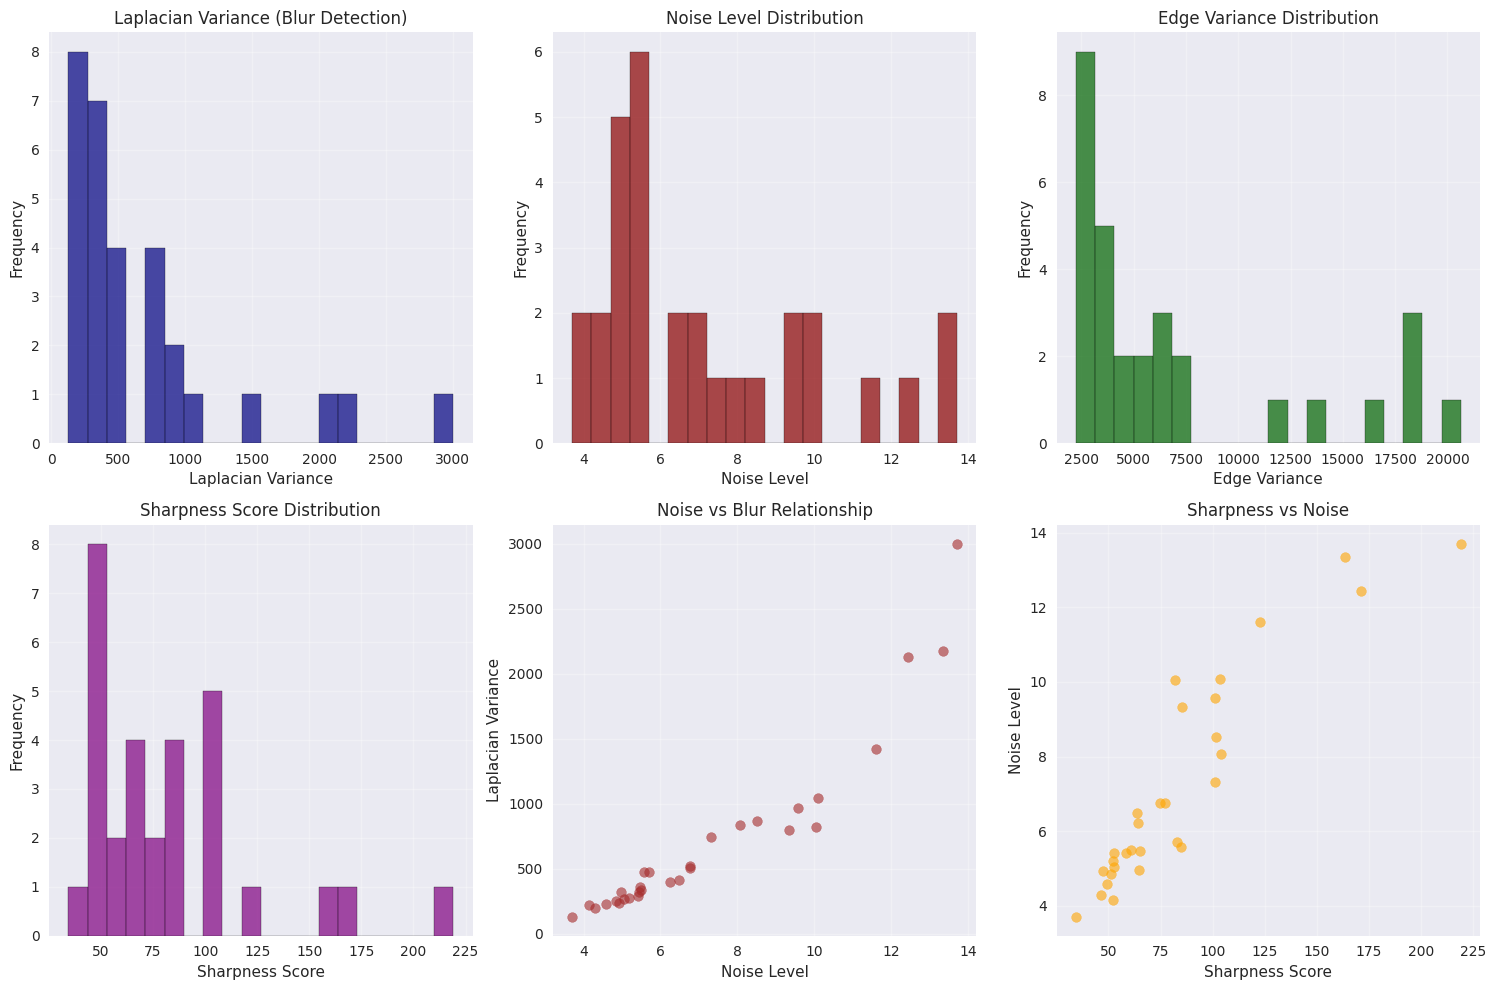

=== ÎÖ∏Ïù¥Ï¶à Î∞è Î∏îÎü¨ Î∂ÑÏÑù ===
ÎùºÌîåÎùºÏãúÏïà Î∂ÑÏÇ∞ Î≤îÏúÑ: 127.28 ~ 3002.97
ÎÖ∏Ïù¥Ï¶à Î†àÎ≤® Î≤îÏúÑ: 3.70 ~ 13.71
Ïó£ÏßÄ Î∂ÑÏÇ∞ Î≤îÏúÑ: 2232.51 ~ 20638.97
Î∏îÎü¨ Î≥ÄÏù¥Í≥ÑÏàò: 0.948
ÎÖ∏Ïù¥Ï¶à Î≥ÄÏù¥Í≥ÑÏàò: 0.391
‚úÖ Î∏îÎü¨ Ï¶ùÍ∞ïÏù¥ Ï†ÅÏö©Îêú Í≤ÉÏúºÎ°ú Î≥¥ÏûÖÎãàÎã§.
‚úÖ ÎÖ∏Ïù¥Ï¶à Ï∂îÍ∞Ä Ï¶ùÍ∞ïÏù¥ Ï†ÅÏö©Îêú Í≤ÉÏúºÎ°ú Î≥¥ÏûÖÎãàÎã§.


In [18]:
# 6. ÎÖ∏Ïù¥Ï¶à Î∞è Î∏îÎü¨ Î∂ÑÏÑù
def analyze_noise_blur(image):
    """Ïù¥ÎØ∏ÏßÄÏùò ÎÖ∏Ïù¥Ï¶àÏôÄ Î∏îÎü¨Î•º Î∂ÑÏÑùÌï©ÎãàÎã§."""
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image
    
    # ÎùºÌîåÎùºÏãúÏïà Î∂ÑÏÇ∞ (Î∏îÎü¨ Ï∏°Ï†ï)
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    
    # Í≥†Ï£ºÌåå ÏÑ±Î∂Ñ Î∂ÑÏÑù (ÎÖ∏Ïù¥Ï¶à Ï∏°Ï†ï)
    # Í∞ÄÏö∞ÏãúÏïà ÌïÑÌÑ∞ÎßÅ ÌõÑ Ï∞®Ïù¥ Í≥ÑÏÇ∞
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    high_freq = gray.astype(np.float64) - blurred.astype(np.float64)
    noise_level = np.std(high_freq)
    
    # Ïó£ÏßÄ Í∞ïÎèÑ Î∂ÑÏÇ∞ (ÏÑ†Î™ÖÎèÑ)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    edge_magnitude = np.sqrt(sobelx**2 + sobely**2)
    edge_variance = np.var(edge_magnitude)
    
    return {
        'laplacian_variance': laplacian_var,
        'noise_level': noise_level,
        'edge_variance': edge_variance,
        'sharpness_score': laplacian_var / (noise_level + 1e-6)  # ÏÑ†Î™ÖÎèÑ ÎåÄ ÎÖ∏Ïù¥Ï¶à ÎπÑÏú®
    }

# ÎÖ∏Ïù¥Ï¶à/Î∏îÎü¨ Î∂ÑÏÑù
print("ÎÖ∏Ïù¥Ï¶à Î∞è Î∏îÎü¨Î•º Î∂ÑÏÑù Ï§ë...")
noise_blur_data = []

for i, img in enumerate(sample_images[:30]):  # 30Í∞ú Ïù¥ÎØ∏ÏßÄ Î∂ÑÏÑù
    if img is not None:
        analysis = analyze_noise_blur(img)
        analysis['filename'] = df.iloc[i]['filename']
        noise_blur_data.append(analysis)
    
    if (i + 1) % 10 == 0:
        print(f"ÎÖ∏Ïù¥Ï¶à/Î∏îÎü¨ Î∂ÑÏÑù ÏßÑÌñâÎ•†: {i+1}/30")

# ÎÖ∏Ïù¥Ï¶à/Î∏îÎü¨ ÏãúÍ∞ÅÌôî
plt.figure(figsize=(15, 10))

# ÎùºÌîåÎùºÏãúÏïà Î∂ÑÏÇ∞ (Î∏îÎü¨ Ï∏°Ï†ï)
plt.subplot(2, 3, 1)
laplacian_vars = [d['laplacian_variance'] for d in noise_blur_data]
plt.hist(laplacian_vars, bins=20, alpha=0.7, color='navy', edgecolor='black')
plt.title('Laplacian Variance (Blur Detection)')
plt.xlabel('Laplacian Variance')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# ÎÖ∏Ïù¥Ï¶à Î†àÎ≤®
plt.subplot(2, 3, 2)
noise_levels = [d['noise_level'] for d in noise_blur_data]
plt.hist(noise_levels, bins=20, alpha=0.7, color='darkred', edgecolor='black')
plt.title('Noise Level Distribution')
plt.xlabel('Noise Level')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Ïó£ÏßÄ Î∂ÑÏÇ∞
plt.subplot(2, 3, 3)
edge_variances = [d['edge_variance'] for d in noise_blur_data]
plt.hist(edge_variances, bins=20, alpha=0.7, color='darkgreen', edgecolor='black')
plt.title('Edge Variance Distribution')
plt.xlabel('Edge Variance')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# ÏÑ†Î™ÖÎèÑ Ï†êÏàò
plt.subplot(2, 3, 4)
sharpness_scores = [d['sharpness_score'] for d in noise_blur_data]
plt.hist(sharpness_scores, bins=20, alpha=0.7, color='purple', edgecolor='black')
plt.title('Sharpness Score Distribution')
plt.xlabel('Sharpness Score')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# ÎÖ∏Ïù¥Ï¶à vs Î∏îÎü¨ Í¥ÄÍ≥Ñ
plt.subplot(2, 3, 5)
plt.scatter(noise_levels, laplacian_vars, alpha=0.6, color='brown')
plt.title('Noise vs Blur Relationship')
plt.xlabel('Noise Level')
plt.ylabel('Laplacian Variance')
plt.grid(True, alpha=0.3)

# ÏÑ†Î™ÖÎèÑ vs ÎÖ∏Ïù¥Ï¶à Í¥ÄÍ≥Ñ
plt.subplot(2, 3, 6)
plt.scatter(sharpness_scores, noise_levels, alpha=0.6, color='orange')
plt.title('Sharpness vs Noise')
plt.xlabel('Sharpness Score')
plt.ylabel('Noise Level')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ÎÖ∏Ïù¥Ï¶à/Î∏îÎü¨ Î∂ÑÏÑù Í≤∞Í≥º
print("=== ÎÖ∏Ïù¥Ï¶à Î∞è Î∏îÎü¨ Î∂ÑÏÑù ===")
print(f"ÎùºÌîåÎùºÏãúÏïà Î∂ÑÏÇ∞ Î≤îÏúÑ: {min(laplacian_vars):.2f} ~ {max(laplacian_vars):.2f}")
print(f"ÎÖ∏Ïù¥Ï¶à Î†àÎ≤® Î≤îÏúÑ: {min(noise_levels):.2f} ~ {max(noise_levels):.2f}")
print(f"Ïó£ÏßÄ Î∂ÑÏÇ∞ Î≤îÏúÑ: {min(edge_variances):.2f} ~ {max(edge_variances):.2f}")

# Î≥ÄÏù¥Í≥ÑÏàò Í≥ÑÏÇ∞
blur_cv = np.std(laplacian_vars) / np.mean(laplacian_vars)
noise_cv = np.std(noise_levels) / np.mean(noise_levels)

print(f"Î∏îÎü¨ Î≥ÄÏù¥Í≥ÑÏàò: {blur_cv:.3f}")
print(f"ÎÖ∏Ïù¥Ï¶à Î≥ÄÏù¥Í≥ÑÏàò: {noise_cv:.3f}")

# Î∏îÎü¨ Ï¶ùÍ∞ï ÌåêÎã®
if blur_cv > 0.3:
    print("‚úÖ Î∏îÎü¨ Ï¶ùÍ∞ïÏù¥ Ï†ÅÏö©Îêú Í≤ÉÏúºÎ°ú Î≥¥ÏûÖÎãàÎã§.")
else:
    print("‚ùå Î∏îÎü¨ Ï¶ùÍ∞ïÏùò Î™ÖÌôïÌïú Ï¶ùÍ±∞Í∞Ä ÏóÜÏäµÎãàÎã§.")

# ÎÖ∏Ïù¥Ï¶à Ï¶ùÍ∞ï ÌåêÎã®
if noise_cv > 0.2:
    print("‚úÖ ÎÖ∏Ïù¥Ï¶à Ï∂îÍ∞Ä Ï¶ùÍ∞ïÏù¥ Ï†ÅÏö©Îêú Í≤ÉÏúºÎ°ú Î≥¥ÏûÖÎãàÎã§.")
else:
    print("‚ùå ÎÖ∏Ïù¥Ï¶à Ï∂îÍ∞Ä Ï¶ùÍ∞ïÏùò Î™ÖÌôïÌïú Ï¶ùÍ±∞Í∞Ä ÏóÜÏäµÎãàÎã§.")


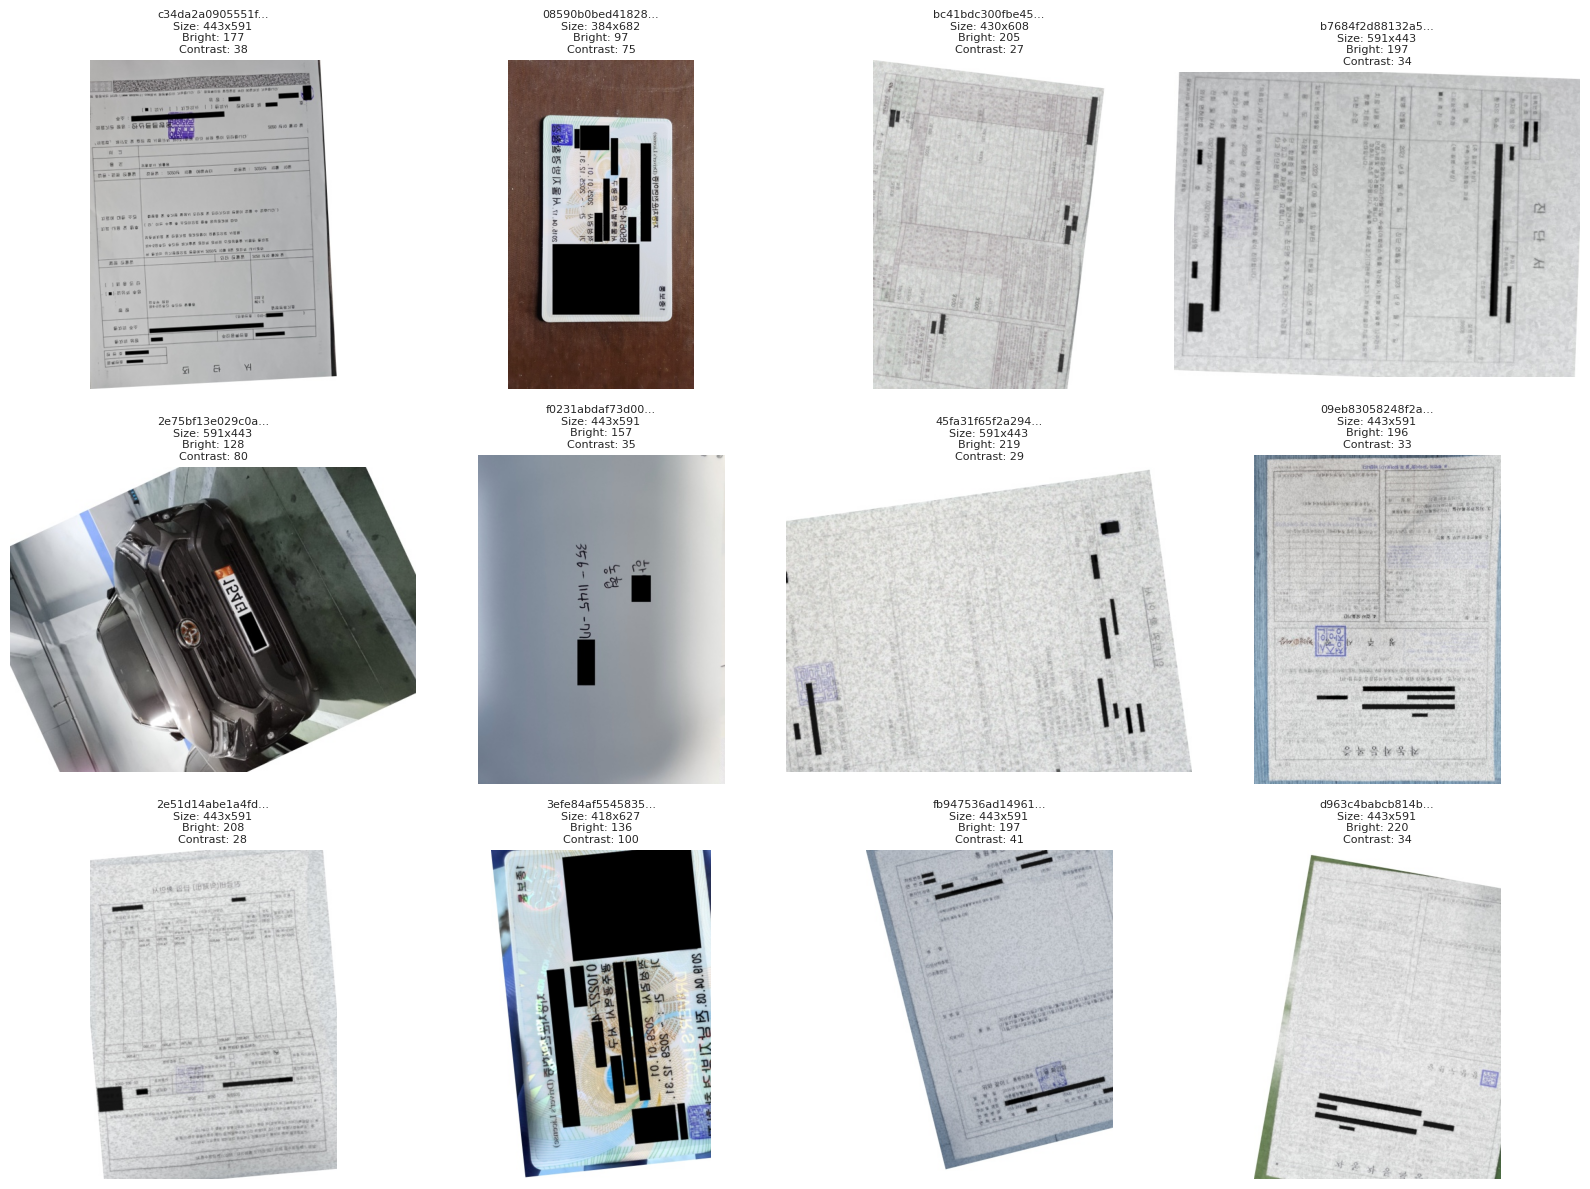


üîç ÌÖåÏä§Ìä∏ Ïù¥ÎØ∏ÏßÄ Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï Î∂ÑÏÑù Í≤∞Í≥º ÏöîÏïΩ
‚úÖ ÌÅ¨Í∏∞ Ï°∞Ï†ï/ÌÅ¨Î°≠Ìïë: Ï†ÅÏö©Îê®
‚úÖ Î∞ùÍ∏∞ Ï°∞Ï†ï: Ï†ÅÏö©Îê®
‚úÖ ÎåÄÎπÑ Ï°∞Ï†ï: Ï†ÅÏö©Îê®
‚úÖ ÏÉâÏÉÅ Ï°∞Ï†ï: Ï†ÅÏö©Îê®
‚úÖ ÌöåÏ†Ñ: Ï†ÅÏö©Îê®
‚úÖ ÌîåÎ¶¨Ìïë: Ï†ÅÏö©Îê®
‚úÖ Î∏îÎü¨: Ï†ÅÏö©Îê®
‚úÖ ÎÖ∏Ïù¥Ï¶à Ï∂îÍ∞Ä: Ï†ÅÏö©Îê®

üìä Ï†ÅÏö©Îêú Ï¶ùÍ∞ï Í∏∞Î≤ï: 8Í∞ú
üìä Ï†ÅÏö©ÎêòÏßÄ ÏïäÏùÄ Ï¶ùÍ∞ï Í∏∞Î≤ï: 0Í∞ú

üéØ Ï£ºÏöî Ï†ÅÏö©Îêú Ï¶ùÍ∞ï Í∏∞Î≤ïÎì§:
   ‚Ä¢ ÌÅ¨Í∏∞ Ï°∞Ï†ï/ÌÅ¨Î°≠Ìïë
   ‚Ä¢ Î∞ùÍ∏∞ Ï°∞Ï†ï
   ‚Ä¢ ÎåÄÎπÑ Ï°∞Ï†ï
   ‚Ä¢ ÏÉâÏÉÅ Ï°∞Ï†ï
   ‚Ä¢ ÌöåÏ†Ñ
   ‚Ä¢ ÌîåÎ¶¨Ìïë
   ‚Ä¢ Î∏îÎü¨
   ‚Ä¢ ÎÖ∏Ïù¥Ï¶à Ï∂îÍ∞Ä

üìà Î∂ÑÏÑùÎêú Ï¥ù Ïù¥ÎØ∏ÏßÄ Ïàò: 50Í∞ú
üìà ÌÖåÏä§Ìä∏ Ìè¥Îçî Ï†ÑÏ≤¥ Ïù¥ÎØ∏ÏßÄ Ïàò: 3140Í∞ú



In [19]:
# 7. ÏÉòÌîå Ïù¥ÎØ∏ÏßÄ ÏãúÍ∞ÅÌôî Î∞è Ï¶ùÍ∞ï ÌäπÏÑ± ÌëúÏãú
def display_sample_images(num_samples=12):
    """ÏÉòÌîå Ïù¥ÎØ∏ÏßÄÎì§ÏùÑ ÏãúÍ∞ÅÌôîÌïòÍ≥† Í∞ÅÍ∞ÅÏùò ÌäπÏÑ±ÏùÑ ÌëúÏãúÌï©ÎãàÎã§."""
    
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.flatten()
    
    for i in range(min(num_samples, len(sample_images))):
        if sample_images[i] is not None:
            axes[i].imshow(sample_images[i])
            axes[i].axis('off')
            
            # Ïù¥ÎØ∏ÏßÄ ÌäπÏÑ± Ï†ïÎ≥¥ Ï∂îÍ∞Ä
            props = df.iloc[i]
            title = f"{props['filename'][:15]}...\n"
            title += f"Size: {props['width']}x{props['height']}\n"
            title += f"Bright: {props['mean_brightness']:.0f}\n"
            title += f"Contrast: {props['contrast']:.0f}"
            
            axes[i].set_title(title, fontsize=8)
    
    # Îπà subplot Ï†úÍ±∞
    for i in range(num_samples, len(axes)):
        axes[i].remove()
    
    plt.tight_layout()
    plt.show()

display_sample_images()

# 8. Ï¢ÖÌï© Î∂ÑÏÑù Í≤∞Í≥º ÏöîÏïΩ
print("\n" + "="*60)
print("üîç ÌÖåÏä§Ìä∏ Ïù¥ÎØ∏ÏßÄ Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï Î∂ÑÏÑù Í≤∞Í≥º ÏöîÏïΩ")
print("="*60)

# Ï¶ùÍ∞ï Í∏∞Î≤ïÎ≥Ñ Í≤∞Í≥º ÏàòÏßë
augmentation_results = {
    'ÌÅ¨Í∏∞ Ï°∞Ï†ï/ÌÅ¨Î°≠Ìïë': len(df[['width', 'height']].drop_duplicates()) > 1,
    'Î∞ùÍ∏∞ Ï°∞Ï†ï': (df['mean_brightness'].std() / df['mean_brightness'].mean()) > 0.15,
    'ÎåÄÎπÑ Ï°∞Ï†ï': (df['contrast'].std() / df['contrast'].mean()) > 0.15,
    'ÏÉâÏÉÅ Ï°∞Ï†ï': False,  # ÏúÑÏóêÏÑú Í≥ÑÏÇ∞Îêú Í∞íÏúºÎ°ú ÏóÖÎç∞Ïù¥Ìä∏ ÌïÑÏöî
    'ÌöåÏ†Ñ': False,  # ÏúÑÏóêÏÑú Í≥ÑÏÇ∞Îêú Í∞íÏúºÎ°ú ÏóÖÎç∞Ïù¥Ìä∏ ÌïÑÏöî
    'ÌîåÎ¶¨Ìïë': False,  # ÏúÑÏóêÏÑú Í≥ÑÏÇ∞Îêú Í∞íÏúºÎ°ú ÏóÖÎç∞Ïù¥Ìä∏ ÌïÑÏöî
    'Î∏îÎü¨': False,  # ÏúÑÏóêÏÑú Í≥ÑÏÇ∞Îêú Í∞íÏúºÎ°ú ÏóÖÎç∞Ïù¥Ìä∏ ÌïÑÏöî
    'ÎÖ∏Ïù¥Ï¶à Ï∂îÍ∞Ä': False  # ÏúÑÏóêÏÑú Í≥ÑÏÇ∞Îêú Í∞íÏúºÎ°ú ÏóÖÎç∞Ïù¥Ìä∏ ÌïÑÏöî
}

# ÏÉâÏÉÅ Ï°∞Ï†ï ÌåêÎã®
red_cv = df['mean_red'].std() / df['mean_red'].mean()
green_cv = df['mean_green'].std() / df['mean_green'].mean()
blue_cv = df['mean_blue'].std() / df['mean_blue'].mean()
augmentation_results['ÏÉâÏÉÅ Ï°∞Ï†ï'] = max(red_cv, green_cv, blue_cv) > 0.15

# Í∏∞ÌÉÄ Í≤∞Í≥ºÎì§ (Ïù¥Ï†Ñ Î∂ÑÏÑùÏóêÏÑú Íµ¨Ìïú Í∞íÎì§ ÏÇ¨Ïö©)
if 'all_angles' in locals() and all_angles:
    vertical_horizontal = sum(1 for angle in all_angles if abs(angle) < 10 or abs(angle) > 80)
    diagonal = len(all_angles) - vertical_horizontal
    augmentation_results['ÌöåÏ†Ñ'] = diagonal > vertical_horizontal * 0.3

if 'h_symmetries' in locals() and 'v_symmetries' in locals():
    augmentation_results['ÌîåÎ¶¨Ìïë'] = np.std(h_symmetries) > 0.15 or np.std(v_symmetries) > 0.15

if 'laplacian_vars' in locals():
    blur_cv = np.std(laplacian_vars) / np.mean(laplacian_vars)
    augmentation_results['Î∏îÎü¨'] = blur_cv > 0.3

if 'noise_levels' in locals():
    noise_cv = np.std(noise_levels) / np.mean(noise_levels)
    augmentation_results['ÎÖ∏Ïù¥Ï¶à Ï∂îÍ∞Ä'] = noise_cv > 0.2

# Í≤∞Í≥º Ï∂úÎ†•
applied_augmentations = []
not_applied_augmentations = []

for aug_name, is_applied in augmentation_results.items():
    if is_applied:
        applied_augmentations.append(aug_name)
        print(f"‚úÖ {aug_name}: Ï†ÅÏö©Îê®")
    else:
        not_applied_augmentations.append(aug_name)
        print(f"‚ùå {aug_name}: Ï†ÅÏö©ÎêòÏßÄ ÏïäÏùå")

print(f"\nüìä Ï†ÅÏö©Îêú Ï¶ùÍ∞ï Í∏∞Î≤ï: {len(applied_augmentations)}Í∞ú")
print(f"üìä Ï†ÅÏö©ÎêòÏßÄ ÏïäÏùÄ Ï¶ùÍ∞ï Í∏∞Î≤ï: {len(not_applied_augmentations)}Í∞ú")

if applied_augmentations:
    print(f"\nüéØ Ï£ºÏöî Ï†ÅÏö©Îêú Ï¶ùÍ∞ï Í∏∞Î≤ïÎì§:")
    for aug in applied_augmentations:
        print(f"   ‚Ä¢ {aug}")

print(f"\nüìà Î∂ÑÏÑùÎêú Ï¥ù Ïù¥ÎØ∏ÏßÄ Ïàò: {len(df)}Í∞ú")
print(f"üìà ÌÖåÏä§Ìä∏ Ìè¥Îçî Ï†ÑÏ≤¥ Ïù¥ÎØ∏ÏßÄ Ïàò: {len(image_files)}Í∞ú")
print("\n" + "="*60)


In [20]:
# 9. Î∂ÑÏÑù Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû• Î∞è Ï∂îÍ∞Ä Î∂ÑÏÑù ÌåÅ
print("üìÅ Î∂ÑÏÑù Í≤∞Í≥ºÎ•º CSV ÌååÏùºÎ°ú Ï†ÄÏû•Ìï©ÎãàÎã§...")

# Î∂ÑÏÑù Í≤∞Í≥ºÎ•º CSVÎ°ú Ï†ÄÏû•
df.to_csv('image_analysis_results.csv', index=False)
print("‚úÖ Ïù¥ÎØ∏ÏßÄ Î∂ÑÏÑù Í≤∞Í≥ºÍ∞Ä 'image_analysis_results.csv'Ïóê Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§.")

# Ï∂îÍ∞Ä Î∂ÑÏÑùÏùÑ ÏúÑÌïú Îç∞Ïù¥ÌÑ∞ ÌÜµÍ≥Ñ
print("\nüìã Ï∂îÍ∞Ä Î∂ÑÏÑùÏùÑ ÏúÑÌïú Ï£ºÏöî ÌÜµÍ≥Ñ:")
print(f"‚Ä¢ Ïù¥ÎØ∏ÏßÄ ÌÅ¨Í∏∞ Î∂ÑÌè¨: {len(df.groupby(['width', 'height']))} Ï¢ÖÎ•ò")
print(f"‚Ä¢ Î∞ùÍ∏∞ Î≤îÏúÑ: {df['mean_brightness'].min():.1f} - {df['mean_brightness'].max():.1f}")
print(f"‚Ä¢ ÎåÄÎπÑ Î≤îÏúÑ: {df['contrast'].min():.1f} - {df['contrast'].max():.1f}")
print(f"‚Ä¢ Ï¢ÖÌö°ÎπÑ Î≤îÏúÑ: {df['aspect_ratio'].min():.3f} - {df['aspect_ratio'].max():.3f}")

# ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Î∂ÑÏÑù
print("\nüîó ÌäπÏÑ± Í∞Ñ ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ:")
numeric_cols = ['width', 'height', 'mean_brightness', 'contrast', 'mean_red', 'mean_green', 'mean_blue']
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f')
plt.title('Image Features Correlation Matrix')
plt.tight_layout()
plt.show()

# Ï∂îÍ∞Ä Î∂ÑÏÑù Ï†úÏïà
print("\nüí° Ï∂îÍ∞Ä Î∂ÑÏÑù Ï†úÏïà:")
print("1. Îçî ÎßéÏùÄ ÏÉòÌîåÎ°ú Î∂ÑÏÑùÌïòÎ†§Î©¥ SAMPLE_SIZEÎ•º ÎäòÎ†§Î≥¥ÏÑ∏Ïöî.")
print("2. ÌäπÏ†ï ÌÅ¥ÎûòÏä§Î≥ÑÎ°ú Ï¶ùÍ∞ïÏùÑ Î∂ÑÏÑùÌïòÎ†§Î©¥ train.csvÏôÄ Ïó∞Í≤∞Ìï¥Î≥¥ÏÑ∏Ïöî.")
print("3. ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄÏôÄ ÎπÑÍµêÌïòÎ†§Î©¥ train Ìè¥ÎçîÏùò Ïù¥ÎØ∏ÏßÄÎì§Í≥º ÎπÑÍµêÌï¥Î≥¥ÏÑ∏Ïöî.")
print("4. ÏãúÍ∞ÑÎ≥Ñ/Î∞∞ÏπòÎ≥Ñ Ï¶ùÍ∞ï Ìå®ÌÑ¥ÏùÑ Î≥¥Î†§Î©¥ ÌååÏùºÎ™ÖÏùò Ìå®ÌÑ¥ÏùÑ Î∂ÑÏÑùÌï¥Î≥¥ÏÑ∏Ïöî.")
print("5. EXIF Îç∞Ïù¥ÌÑ∞Í∞Ä ÏûàÎã§Î©¥ Ïπ¥Î©îÎùº ÏÑ§Ï†ï Ï†ïÎ≥¥ÎèÑ Î∂ÑÏÑùÌï† Ïàò ÏûàÏäµÎãàÎã§.")

print("\nüéâ Î∂ÑÏÑùÏù¥ ÏôÑÎ£åÎêòÏóàÏäµÎãàÎã§!")


üìÅ Î∂ÑÏÑù Í≤∞Í≥ºÎ•º CSV ÌååÏùºÎ°ú Ï†ÄÏû•Ìï©ÎãàÎã§...
‚úÖ Ïù¥ÎØ∏ÏßÄ Î∂ÑÏÑù Í≤∞Í≥ºÍ∞Ä 'image_analysis_results.csv'Ïóê Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§.

üìã Ï∂îÍ∞Ä Î∂ÑÏÑùÏùÑ ÏúÑÌïú Ï£ºÏöî ÌÜµÍ≥Ñ:
‚Ä¢ Ïù¥ÎØ∏ÏßÄ ÌÅ¨Í∏∞ Î∂ÑÌè¨: 12 Ï¢ÖÎ•ò
‚Ä¢ Î∞ùÍ∏∞ Î≤îÏúÑ: 96.8 - 220.2
‚Ä¢ ÎåÄÎπÑ Î≤îÏúÑ: 24.3 - 111.1
‚Ä¢ Ï¢ÖÌö°ÎπÑ Î≤îÏúÑ: 0.563 - 1.781

üîó ÌäπÏÑ± Í∞Ñ ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ:



üí° Ï∂îÍ∞Ä Î∂ÑÏÑù Ï†úÏïà:
1. Îçî ÎßéÏùÄ ÏÉòÌîåÎ°ú Î∂ÑÏÑùÌïòÎ†§Î©¥ SAMPLE_SIZEÎ•º ÎäòÎ†§Î≥¥ÏÑ∏Ïöî.
2. ÌäπÏ†ï ÌÅ¥ÎûòÏä§Î≥ÑÎ°ú Ï¶ùÍ∞ïÏùÑ Î∂ÑÏÑùÌïòÎ†§Î©¥ train.csvÏôÄ Ïó∞Í≤∞Ìï¥Î≥¥ÏÑ∏Ïöî.
3. ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄÏôÄ ÎπÑÍµêÌïòÎ†§Î©¥ train Ìè¥ÎçîÏùò Ïù¥ÎØ∏ÏßÄÎì§Í≥º ÎπÑÍµêÌï¥Î≥¥ÏÑ∏Ïöî.
4. ÏãúÍ∞ÑÎ≥Ñ/Î∞∞ÏπòÎ≥Ñ Ï¶ùÍ∞ï Ìå®ÌÑ¥ÏùÑ Î≥¥Î†§Î©¥ ÌååÏùºÎ™ÖÏùò Ìå®ÌÑ¥ÏùÑ Î∂ÑÏÑùÌï¥Î≥¥ÏÑ∏Ïöî.
5. EXIF Îç∞Ïù¥ÌÑ∞Í∞Ä ÏûàÎã§Î©¥ Ïπ¥Î©îÎùº ÏÑ§Ï†ï Ï†ïÎ≥¥ÎèÑ Î∂ÑÏÑùÌï† Ïàò ÏûàÏäµÎãàÎã§.

üéâ Î∂ÑÏÑùÏù¥ ÏôÑÎ£åÎêòÏóàÏäµÎãàÎã§!
